In [1]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))


import torch
import torch.nn as nn
import torchinfo
from tqdm.notebook import tqdm 

from torchvision.datasets import Caltech101
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms


from vision_transformer.VisionTransformer import ViT
from src.read_config import read_config

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
config = read_config(config_path='../configs', config_name='architecture_2.yaml')
config

{'inputs': {'img_size': 96, 'in_channels': 3}, 'params': {'patch_size': 8, 'd_model': 512, 'dropout_rate': 0.5, 'n_encoder_blocks': 2, 'n_heads': 4, 'ff_size': 1024}}

In [3]:
class TransformerClassifier(nn.Module): 
    def __init__(self, n_classes, img_size: int, in_channels: int, transformer_config): 
        super().__init__()
        
        self.n_classes = n_classes
        self.img_size = img_size
        self.in_channels = in_channels
        self.transformer_config = transformer_config
        
        self.vit = ViT(img_size=img_size, in_channels=in_channels, **self.transformer_config)

        self.classifier = nn.Sequential(
            nn.Linear(self.vit.d_model, self.n_classes), 
            nn.ReLU(), 
        )
        
    def forward(self, x): 
        embeddins = self.vit(x)
        logits = self.classifier(embeddins)
        
        return logits

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((config.inputs.img_size, config.inputs.img_size))
])

dataset = Caltech101(root='./data', download=True, transform=transform)
filtered_indices = []
for img_id in range(len(dataset)):
    img, label = dataset[img_id]
    if img.shape[0] == 3:
        filtered_indices.append(img_id)

filtered_dataset = Subset(dataset, filtered_indices)
train_loader = DataLoader(filtered_dataset, batch_size=20, shuffle=True)

Files already downloaded and verified


In [5]:
def plot_images(images, labels, text_labels, n_images=5):
    fig, axes = plt.subplots(1,min(n_images, len(labels)), figsize=(20, 20))
    for i, (img, label) in enumerate(zip(images, labels[:min(n_images, len(labels))])):
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        axes[i].imshow(img)
        axes[i].set_title(f'Label: {label}\n{text_labels[label]}')
        axes[i].axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


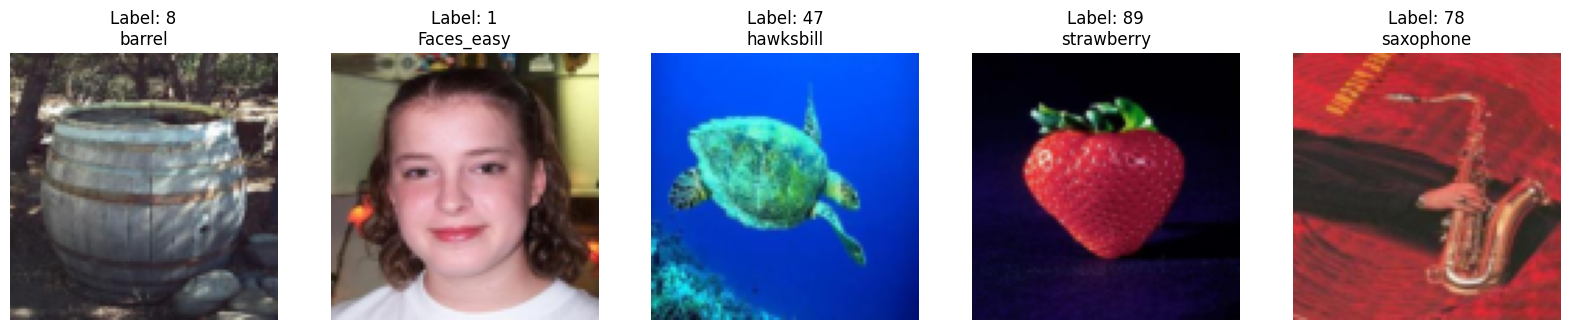

In [6]:
for images, labels in train_loader:
    plot_images(images, labels, dataset.categories, n_images=5)
    break

In [7]:
def train(model, optimizer, loss_fn, train_loader, epochs, device): 
    model = model.to(device)
    
    for epoch in range(epochs):
        train_loop = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}")
        model.train() 
        
        train_loss = 0.0
        for data in train_loop:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device) 
            preds = model(inputs)

            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()   
            train_loop.set_postfix({"mean_loss": train_loss / len(train_loader)})

In [8]:
model = TransformerClassifier(n_classes=101, img_size=config.inputs.img_size, in_channels=config.inputs.in_channels, transformer_config=config['params'])
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.000007)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [9]:
print(torchinfo.summary(model, (1, config.inputs.in_channels, config.inputs.img_size, config.inputs.img_size), device='cpu'))

Layer (type:depth-idx)                                  Output Shape              Param #
TransformerClassifier                                   [1, 101]                  --
├─ViT: 1-1                                              [1, 512]                  512
│    └─PatchEmbedder: 2-1                               [1, 144, 512]             --
│    │    └─Conv2d: 3-1                                 [1, 512, 12, 12]          98,816
│    └─PositionalEncoding: 2-2                          [1, 144, 512]             --
│    └─Encoder: 2-3                                     [1, 145, 512]             --
│    │    └─ModuleList: 3-2                             --                        4,201,480
│    │    └─LayerNorm: 3-3                              [1, 145, 512]             2
├─Sequential: 1-2                                       [1, 101]                  --
│    └─Linear: 2-4                                      [1, 101]                  51,813
│    └─ReLU: 2-5                             

In [13]:
train(
    model=model, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0.000003), 
    loss_fn = loss, 
    train_loader=train_loader, 
    epochs=60, 
    device=device,
)

Epoch 0:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 6:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 7:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 8:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 9:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 10:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 11:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 12:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 13:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 14:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 15:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 16:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 17:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 18:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 19:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 20:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 21:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 22:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 23:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 24:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 25:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 26:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 27:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 28:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 29:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 30:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 31:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 32:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 33:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 34:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 35:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 36:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 37:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 38:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 39:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 40:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 41:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 42:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 43:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 44:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 45:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 46:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 47:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 48:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 49:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 50:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 51:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 52:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 53:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 54:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 55:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 56:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 57:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 58:   0%|          | 0/415 [00:00<?, ?it/s]

Epoch 59:   0%|          | 0/415 [00:00<?, ?it/s]

In [14]:
torch.save(model.state_dict(), 'architecture_2.pth')